In [1]:
# librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score,
                             confusion_matrix)

In [2]:
# funciones auxiliares
def load_and_preprocess_images(spec_df, mfcc_df):
    spects = []
    mfcc = []
    labels = []

    for _, row in spec_df.iterrows():
        # Cargar la imagen desde la ubicación
        image = load_img(row['ubicacion'], target_size=(310, 154))  # Ajusta el tamaño de imagen
        # convertimos la imagen a matriz
        image = img_to_array(image)
        # pegamos en la lista la matriz de la imagen
        spects.append(image)
        # pegamos en la lista, la etiqueta correspondiente
        labels.append(row['label'])
        # print(row['label'])

        
    for i, row in mfcc_df.iterrows():
        # Cargar la imagen desde la ubicación
        image = load_img(row['ubicacion'], target_size=(310, 154))  # Ajusta el tamaño de imagen
        # convertimos la imagen a matriz
        image = img_to_array(image)
        # pegamos en la lista la matriz de la imagen
        mfcc.append(image)
        # pegamos en la lista, la etiqueta correspondiente
        # labels.append(row['label'])
        
        # print(row['label'])

    # Convertir a numpy array
    spects = np.array(spects)
    mfcc = np.array(mfcc)
    
    # Codificar las etiquetas

    return spects, mfcc, np.array(labels).astype(int)

def create_model():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(310, 154, 3)),
        # layers.Conv2D(16, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.4),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        # layers.Dropout(0.4),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        # layers.Dropout(0.4),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        # layers.Dropout(0.4),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        # layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        # layers.Normalization(mean=0, variance=1),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        # layers.Dense(64, activation='relu'),
        # layers.Dropout(0.4),
        layers.Dense(1, activation = 'linear')
    ])

    return model

def model2():
    l2_regularizer = 0.1

    spect_NN = tf.keras.models.Sequential([
        layers.Rescaling(1./255, input_shape=(310, 154, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_regularizer=l2(l2_regularizer)),
        layers.Dropout(0.4),
        layers.Dense(64, activation = 'relu', kernel_regularizer=l2(l2_regularizer)),
    ])

    mfcc_NN = tf.keras.models.Sequential([
        layers.Rescaling(1./255, input_shape=(310, 154, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2_regularizer)),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_regularizer=l2(l2_regularizer)),
        layers.Dropout(0.4),
        layers.Dense(64, activation = 'relu', kernel_regularizer=l2(l2_regularizer)),
    ])

    # create the user input and point to the base network
    input_spect = tf.keras.layers.Input(shape=(310, 154, 3))
    spect = spect_NN(input_spect)
    spect = tf.linalg.l2_normalize(spect, axis=1)

    # create the item input and point to the base network
    input_mfcc = tf.keras.layers.Input(shape=(310, 154, 3))
    mfcc = mfcc_NN(input_mfcc)
    mfcc = tf.linalg.l2_normalize(mfcc, axis=1)

    # compute the dot product of the two vectors spect and mfcc
    x = layers.Concatenate(axis=1)([spect, mfcc])
    x = layers.Dense(200, activation='relu')(x)
    # x = layers.Dropout(0.4)(x),
    x = layers.Dense(1)(x)

    # specify the inputs and output of the model
    model = Model([input_spect, input_mfcc], x)

    return model

def compile_fit_model2(model, X_train_spect, X_train_mfcc, X_test_spect, X_test_mfcc, y_train, y_test, epochs = 30, lr = 0.00001):
    model.compile(
        optimizer = Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    history = model.fit(
        [X_train_spect, X_train_mfcc],
        y_train,
        epochs = epochs,
        validation_data = ([X_test_spect, X_test_mfcc], y_test),
        batch_size = 3,
        verbose = 0
    )

    return model, history

    
def compile_fit_model(model, X_train, y_train, epochs = 60, lr = 0.0001):
    model.compile(
        optimizer = Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics = ['accuracy']
    )

    history = model.fit(
        X_train,
        y_train,
        epochs = epochs,
        # validation_data = (X_test, y_test),
        batch_size = 3,
        verbose = 0
    )

    return model, history

def group_stratified_train_test(df_spec, df_mfcc, random_state: int):
    unique_ids = df_spec[['id', 'label']].drop_duplicates()

    train, test = train_test_split(unique_ids, test_size=0.25, stratify=unique_ids['label'], random_state=random_state, shuffle=True)

    train_ids = np.array(train['id'])
    test_ids = np.array(test['id'])

    train_ids_index = np.where(df_spec['id'].isin(train_ids))[0].astype(int)
    test_ids_index = np.where(df_spec['id'].isin(test_ids))[0].astype(int)

    return df_spec.iloc[train_ids_index], df_spec.iloc[test_ids_index], df_mfcc.iloc[train_ids_index], df_mfcc.iloc[test_ids_index]


# obtener especificidad
def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()

    return tn / (tn + fp)

def model2_evaluate(model, X_spect, X_mfcc):
    logits = model.predict([X_spect, X_mfcc], verbose=0)
    probs = tf.squeeze(tf.nn.sigmoid(logits))
    y_preds = tf.where(probs <= 0.5, 0, 1)

    return y_preds.numpy()

def model_evaluate(model, X_data):
    logits = model.predict(X_data, verbose=0)
    probs = tf.squeeze(tf.nn.sigmoid(logits))
    y_preds = tf.where(probs <= 0.5, 0, 1)

    return y_preds.numpy()

In [3]:
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

# Verificar qué dispositivo está siendo utilizado actualmente
print("Dispositivo actual:", tf.test.gpu_device_name() if tf.test.gpu_device_name() else "CPU")

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Dispositivo actual: /device:GPU:0


In [4]:
# seeds
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
# tf.config.experimental.enable_op_determinism()

In [5]:
spects_df = pd.read_csv("newspect pacientes.csv", dtype=object, index_col=None, encoding="latin1")
spects_df = spects_df.drop(columns=["Unnamed: 0"])
spects_df.head()

,ubicación old,label,repeticion,paciente,id,ubicacion
0,C:\Users\ricar\OneDrive\Documentos\Tesis\NewSp...,0,R1,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
1,C:\Users\ricar\OneDrive\Documentos\Tesis\NewSp...,0,R2,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
2,C:\Users\ricar\OneDrive\Documentos\Tesis\NewSp...,0,R3,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
3,C:\Users\ricar\OneDrive\Documentos\Tesis\NewSp...,0,R1,03,003,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
4,C:\Users\ricar\OneDrive\Documentos\Tesis\NewSp...,0,R2,03,003,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...


In [6]:
mfcc_df = pd.read_csv("mfcc pacientes.csv", dtype=object, index_col=None, encoding="latin1")
mfcc_df = mfcc_df.drop(columns=["Unnamed: 0"])
mfcc_df.head()

,ubicación old,label,repeticion,paciente,id,ubicacion
0,\Control\CONT2014-0002T1R1.png,0,R1,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
1,\Control\CONT2014-0002T1R2.png,0,R2,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
2,\Control\CONT2014-0002T1R3.png,0,R3,02,002,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
3,\Control\CONT2014-0003T1R1.png,0,R1,03,003,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...
4,\Control\CONT2014-0003T1R2.png,0,R2,03,003,C:\Users\ricar\OneDrive\Documentos\Tesis\data\...


In [7]:
k = 1
test_metrics = np.zeros(shape=(k, 4))
test_acc_classes = np.zeros(shape=(k, 2))

# test_acc_rep = np.zeros(shape=(k, 3))
# test_prec_rep = np.zeros(shape=(k, 3))
# test_rec_rep = np.zeros(shape=(k, 3))
# test_spec_rep = np.zeros(shape=(k, 3))

for i in range(k):
    # notar que con cada iteracion la semilla cambia y por ende, obtenemos conjuntos de entrenamiento y de prueba diferentes
    train_spec, test_spec, mfcc_train, mfcc_test = group_stratified_train_test(df_spec=spects_df, df_mfcc=mfcc_df, random_state=i)
    
    # generamos nuestros conjuntos de entrenamiento o prueba
    X_train_spec, X_train_mfcc, y_train = load_and_preprocess_images(spec_df=train_spec, mfcc_df=mfcc_train)
    X_test_spec, X_test_mfcc, y_test = load_and_preprocess_images(spec_df=test_spec, mfcc_df=mfcc_test)

    # print(X_train_spec.shape, X_test_spec.shape, y_train.shape, X_train_spec.shape, X_test_mfcc.shape, y_test.shape)

    # entrenamos nuestro modelo
    model = model2()

    model, _ = compile_fit_model2(model, 
                                  X_train_spect=X_train_spec, 
                                  X_train_mfcc=X_train_mfcc, 
                                  X_test_spect=X_test_spec, 
                                  X_test_mfcc=X_test_mfcc, 
                                  y_train=y_train,
                                  y_test = y_test,
                                  epochs = 30)
    
    y_test_preds =  model2_evaluate(model=model, X_spect=X_test_spec, X_mfcc=X_test_mfcc)

    # metricas sin considerar grupos
    test_metrics[i, ] = [accuracy_score(y_pred=y_test_preds, 
                                        y_true=y_test),
                         precision_score(y_pred=y_test_preds, 
                                         y_true=y_test),
                         recall_score(y_pred=y_test_preds, 
                                      y_true=y_test),
                         specificity_score(y_pred=y_test_preds, 
                                           y_true=y_test)]
    
    # # accuracy por clase
    # test_acc_classes[i, ] = accuracy_per_class(y_pred=y_test_preds, y_true=y_test)

    print(f"***********************new set {i}**************************")
    
    # limpiamos la sesion
    del(model, X_train_mfcc, X_train_spec, y_train, X_test_mfcc, X_test_spec, y_test)
    tf.keras.backend.clear_session()

***********************new set 0**************************


In [8]:
test_metrics

array([[0.65      , 0.6097561 , 0.83333333, 0.46666667]])

Con Espectrogramas de mel

In [9]:
k = 5
test_metrics = np.zeros(shape=(k, 4))
test_acc_classes = np.zeros(shape=(k, 2))

# test_acc_rep = np.zeros(shape=(k, 3))
# test_prec_rep = np.zeros(shape=(k, 3))
# test_rec_rep = np.zeros(shape=(k, 3))
# test_spec_rep = np.zeros(shape=(k, 3))

# return df_spec.iloc[train_ids_index], df_spec.iloc[test_ids_index], df_mfcc.iloc[train_ids_index], df_mfcc.iloc[test_ids_index]

# return spects, mfcc, np.array(labels).astype(int)

for i in range(k):
    # notar que con cada iteracion la semilla cambia y por ende, obtenemos conjuntos de entrenamiento y de prueba diferentes
    train_spec, test_spec, mfcc_train, mfcc_test  = group_stratified_train_test(df_mfcc=mfcc_df, df_spec=spects_df, random_state=i)
    
    # generamos nuestros conjuntos de entrenamiento o prueba
    X_train_spec, _, y_train = load_and_preprocess_images(spec_df=train_spec, mfcc_df=mfcc_train)
    X_test_spec, _, y_test = load_and_preprocess_images(spec_df=test_spec, mfcc_df=mfcc_test)

    # entrenamos nuestro modelo
    model = create_model()

    model, _ = compile_fit_model(model, X_train=X_train_spec, y_train=y_train)
    
    y_test_preds =  model_evaluate(model=model, X_data=X_test_spec)

    # metricas sin considerar grupos
    test_metrics[i, ] = [accuracy_score(y_pred=y_test_preds, 
                                        y_true=y_test),
                         precision_score(y_pred=y_test_preds, 
                                         y_true=y_test),
                         recall_score(y_pred=y_test_preds, 
                                      y_true=y_test),
                         specificity_score(y_pred=y_test_preds, 
                                           y_true=y_test)]
    
    # accuracy por clase
    # test_acc_classes[i, ] = accuracy_per_class(y_pred=y_test_preds, y_true=y_test)

    print(f"***********************new set {i+1}**************************")
    
    # limpiamos la sesion
    del(model, X_train_spec, y_train, X_test_spec, y_test)
    tf.keras.backend.clear_session()

***********************new set 1**************************
***********************new set 2**************************
***********************new set 3**************************
***********************new set 4**************************
***********************new set 5**************************


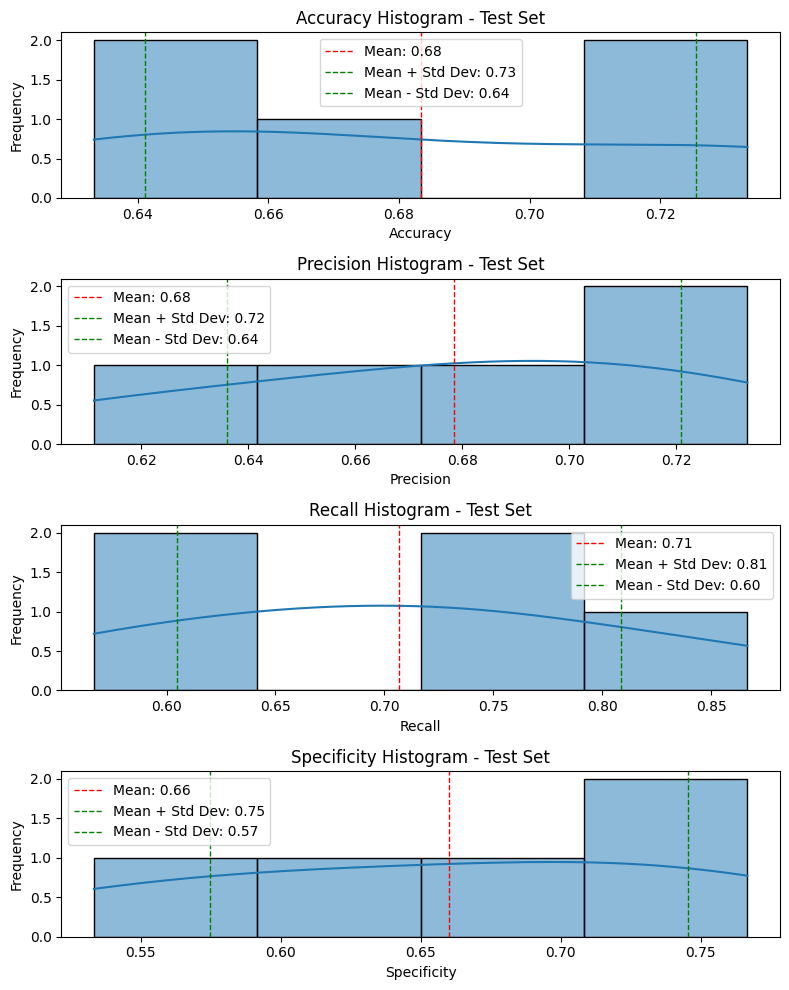

In [11]:
# graficas de las métricas de accuracy, precision, recall y specificity
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity']

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

for i in range(4):
    sns.histplot(test_metrics[:, i], ax=axs[i], kde=True)
    axs[i].axvline(test_metrics[:, i].mean(), 
                   color='red', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean: {test_metrics[:, i].mean():.2f}')
    axs[i].axvline(test_metrics[:, i].mean() + test_metrics[:, i].std(), 
                   color='green', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean + Std Dev: {test_metrics[:, i].mean() + test_metrics[:, i].std():.2f}')
    axs[i].axvline(test_metrics[:, i].mean() - test_metrics[:, i].std(), 
                   color='green', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean - Std Dev: {test_metrics[:, i].mean() - test_metrics[:, i].std():.2f}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(metrics_names[i])
    axs[i].set_title(f'{metrics_names[i]} Histogram - Test Set')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [8]:
k = 5
test_metrics = np.zeros(shape=(k, 4))
test_acc_classes = np.zeros(shape=(k, 2))

# test_acc_rep = np.zeros(shape=(k, 3))
# test_prec_rep = np.zeros(shape=(k, 3))
# test_rec_rep = np.zeros(shape=(k, 3))
# test_spec_rep = np.zeros(shape=(k, 3))

# return df_spec.iloc[train_ids_index], df_spec.iloc[test_ids_index], df_mfcc.iloc[train_ids_index], df_mfcc.iloc[test_ids_index]

# return spects, mfcc, np.array(labels).astype(int)

for i in range(k):
    # notar que con cada iteracion la semilla cambia y por ende, obtenemos conjuntos de entrenamiento y de prueba diferentes
    train_spec, test_spec, mfcc_train, mfcc_test  = group_stratified_train_test(df_mfcc=mfcc_df, df_spec=spects_df, random_state=i)
    
    # generamos nuestros conjuntos de entrenamiento o prueba
    _, X_train_mfcc, y_train = load_and_preprocess_images(spec_df=train_spec, mfcc_df=mfcc_train)
    _, X_test_mfcc, y_test = load_and_preprocess_images(spec_df=test_spec, mfcc_df=mfcc_test)

    # entrenamos nuestro modelo
    model = create_model()

    model, _ = compile_fit_model(model, X_train=X_train_mfcc, y_train=y_train)
    
    y_test_preds =  model_evaluate(model=model, X_data=X_test_mfcc)

    # metricas sin considerar grupos
    test_metrics[i, ] = [accuracy_score(y_pred=y_test_preds, 
                                        y_true=y_test),
                         precision_score(y_pred=y_test_preds, 
                                         y_true=y_test),
                         recall_score(y_pred=y_test_preds, 
                                      y_true=y_test),
                         specificity_score(y_pred=y_test_preds, 
                                           y_true=y_test)]
    
    # accuracy por clase
    # test_acc_classes[i, ] = accuracy_per_class(y_pred=y_test_preds, y_true=y_test)

    print(f"***********************new set {i+1}**************************")
    
    # limpiamos la sesion
    del(model, X_train_mfcc, y_train, X_test_mfcc, y_test)
    tf.keras.backend.clear_session()

***********************new set 1**************************
***********************new set 2**************************
***********************new set 3**************************
***********************new set 4**************************
***********************new set 5**************************


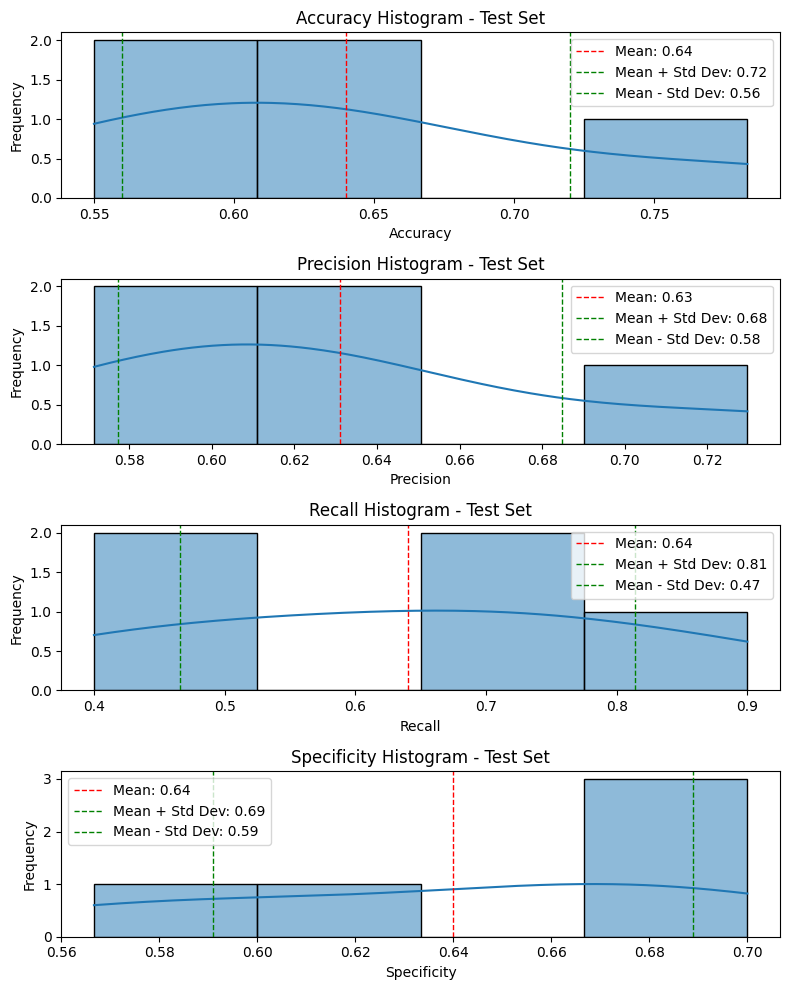

In [9]:
# graficas de las métricas de accuracy, precision, recall y specificity
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity']

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

for i in range(4):
    sns.histplot(test_metrics[:, i], ax=axs[i], kde=True)
    axs[i].axvline(test_metrics[:, i].mean(), 
                   color='red', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean: {test_metrics[:, i].mean():.2f}')
    axs[i].axvline(test_metrics[:, i].mean() + test_metrics[:, i].std(), 
                   color='green', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean + Std Dev: {test_metrics[:, i].mean() + test_metrics[:, i].std():.2f}')
    axs[i].axvline(test_metrics[:, i].mean() - test_metrics[:, i].std(), 
                   color='green', 
                   linestyle='dashed', 
                   linewidth=1, 
                   label=f'Mean - Std Dev: {test_metrics[:, i].mean() - test_metrics[:, i].std():.2f}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(metrics_names[i])
    axs[i].set_title(f'{metrics_names[i]} Histogram - Test Set')
    axs[i].legend()

plt.tight_layout()
plt.show()